In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/programming projects/data analyst/portafolio/dataframes/cafe_sales.csv', sep=',')

In [3]:
# see the first and last rows of the dataframe
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [4]:
df.dtypes

Transaction ID      object
Item                object
Quantity            object
Price Per Unit      object
Total Spent         object
Payment Method      object
Location            object
Transaction Date    object
dtype: object

In [5]:
# Count the number of 'UNKNOWN', 'ERROR' and nan values in each column
unknown_counts = df.apply(lambda x: x.str.contains('UNKNOWN', na=False).sum())
error_counts = df.apply(lambda x: x.str.contains('ERROR', na=False).sum())
nan_counts = df.isna().sum()

# Sum all the errors per column
total_errors = unknown_counts + error_counts + nan_counts

# show the results
print("Count of 'UNKNOWN' by column:")
print(unknown_counts)
print("\nCount of 'ERROR' by column:")
print(error_counts)
print("\nCount of 'nan' by column:")
print(nan_counts)
print("\nTotal errors by column:")
print(total_errors)

Count of 'UNKNOWN' by column:
Transaction ID        0
Item                344
Quantity            171
Price Per Unit      164
Total Spent         165
Payment Method      293
Location            338
Transaction Date    159
dtype: int64

Count of 'ERROR' by column:
Transaction ID        0
Item                292
Quantity            170
Price Per Unit      190
Total Spent         164
Payment Method      306
Location            358
Transaction Date    142
dtype: int64

Count of 'nan' by column:
Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

Total errors by column:
Transaction ID         0
Item                 969
Quantity             479
Price Per Unit       533
Total Spent          502
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64


In [6]:
#At first glance we can see that Item, Quantity and Price Per Unit have values ​​such as error, unknow and nan,
#so we can create a list with the products and prices of all options to complete these errors
menu = {
    "Coffee": 2.0,
    "Tea": 1.5,
    "Sandwich": 4.0,
    "Salad": 5.0,
    "Cake": 3.0,
    "Cookie": 1.0,
    "Smoothie": 4.0,
    "Juice": 3.0
}

In [7]:
# Convert numeric columns
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Total Spent'] = pd.to_numeric(df['Total Spent'], errors='coerce')
df['Price Per Unit'] = pd.to_numeric(df['Price Per Unit'], errors='coerce')

# Step 1: Correct the 'Item' column using the dictionary and relations between columns
def fix_item(row):
    if row['Item'] in ['ERROR', 'UNKNOWN', np.nan]:
        # Case 1: If Price Per Unit is valid, look for the corresponding item in the menu
        if pd.notna(row['Price Per Unit']) and row['Price Per Unit'] in menu.values():
            item = [k for k, v in menu.items() if v == row['Price Per Unit']][0]
            return item
        # Case 2: If Total Spent and Quantity are valid, infer Price Per Unit and then the item
        elif pd.notna(row['Total Spent']) and pd.notna(row['Quantity']):
            inferred_price = row['Total Spent'] / row['Quantity']
            if inferred_price in menu.values():
                item = [k for k, v in menu.items() if v == inferred_price][0]
                return item
    return row['Item']

df['Item'] = df.apply(fix_item, axis=1)

# Step 2: Correct 'Price Per Unit' using the valid item
df['Price Per Unit'] = df.apply(
    lambda x: menu[x['Item']] if (x['Item'] in menu) and (pd.isna(x['Price Per Unit']) or x['Price Per Unit'] in ['ERROR', 'UNKNOWN']) else x['Price Per Unit'],
    axis=1
)

# Step 3: Correct 'Quantity' and 'Total Spent' using mathematical relationships
df['Quantity'] = df.apply(
    lambda x: x['Total Spent'] / x['Price Per Unit'] if pd.isna(x['Quantity']) and pd.notna(x['Total Spent']) and pd.notna(x['Price Per Unit']) else x['Quantity'],
    axis=1
)

df['Total Spent'] = df.apply(
    lambda x: x['Quantity'] * x['Price Per Unit'] if pd.isna(x['Total Spent']) and pd.notna(x['Quantity']) and pd.notna(x['Price Per Unit']) else x['Total Spent'],
    axis=1
)

# Step 4: Price cross validation
df['Price Per Unit'] = df.apply(
    lambda x: menu[x['Item']] if (x['Item'] in menu) and (x['Price Per Unit'] != menu[x['Item']]) else x['Price Per Unit'],
    axis=1
)


In [8]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [9]:
# Count values ​​after cleaning
unknown_counts_after = df.apply(lambda x: x.astype(str).str.contains('UNKNOWN', na=False).sum())
error_counts_after = df.apply(lambda x: x.astype(str).str.contains('ERROR', na=False).sum())
nan_counts_after = df.isna().sum()

# Add all errors by column
total_errors_after = unknown_counts_after + error_counts_after + nan_counts_after

# Show the results after cleaning
print("\nDespués de la limpieza:")
print("Count of 'UNKNOWN' by column:")
print(unknown_counts_after)
print("\nCount of 'ERROR' by column:")
print(error_counts_after)
print("\nCount of 'nan' by column:")
print(nan_counts_after)
print("\nTotal errors by column:")
print(total_errors_after)


Después de la limpieza:
Count of 'UNKNOWN' by column:
Transaction ID        0
Item                  2
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method      293
Location            338
Transaction Date    159
dtype: int64

Count of 'ERROR' by column:
Transaction ID        0
Item                  2
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method      306
Location            358
Transaction Date    142
dtype: int64

Count of 'nan' by column:
Transaction ID         0
Item                   2
Quantity              23
Price Per Unit         6
Total Spent           23
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

Total errors by column:
Transaction ID         0
Item                   6
Quantity              23
Price Per Unit         6
Total Spent           23
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64


In [10]:
# rows with 'ERROR' in 'Item'
error_item_rows = df[df['Item'] == 'ERROR']

# rows with 'UNKNOWN' in 'Item'
unknown_item_rows = df[df['Item'] == 'UNKNOWN']

# rows with NaN in 'Item', 'Quantity', 'Price Per Unit' y 'Total Spent'
nan_rows = df[df[['Item', 'Quantity', 'Price Per Unit', 'Total Spent']].isna().any(axis=1)]

# show rows
print("Rows with 'ERROR' in 'Item':")
print(error_item_rows)

print("\nRows with 'UNKNOWN' in 'Item':")
print(unknown_item_rows)

print("\nRows with NaN in 'Item', 'Quantity', 'Price Per Unit' y 'Total Spent':")
print(nan_rows)

Rows with 'ERROR' in 'Item':
     Transaction ID   Item  Quantity  Price Per Unit  Total Spent  \
4152    TXN_9646000  ERROR       2.0             NaN          NaN   
7597    TXN_1082717  ERROR       NaN             NaN          9.0   

      Payment Method  Location Transaction Date  
4152             NaN  In-store       2023-12-14  
7597  Digital Wallet  In-store       2023-12-13  

Rows with 'UNKNOWN' in 'Item':
     Transaction ID     Item  Quantity  Price Per Unit  Total Spent  \
2289    TXN_7524977  UNKNOWN       4.0             NaN          NaN   
3779    TXN_7376255  UNKNOWN       NaN             NaN         25.0   

     Payment Method  Location Transaction Date  
2289          ERROR       NaN       2023-12-09  
3779            NaN  In-store       2023-05-27  

Rows with NaN in 'Item', 'Quantity', 'Price Per Unit' y 'Total Spent':
     Transaction ID      Item  Quantity  Price Per Unit  Total Spent  \
236     TXN_8562645     Salad       NaN             5.0          NaN   
278 

In [11]:
# Step 6: Eliminate rows that still contain invalid/null values ​​in these columns
columns_to_clean = ['Item', 'Quantity', 'Price Per Unit', 'Total Spent']
df = df.dropna(subset=columns_to_clean).reset_index(drop=True)
df = df[~df['Item'].isin(['ERROR', 'UNKNOWN'])].reset_index(drop=True)

In [12]:
# Count values ​​after cleaning
unknown_counts_after = df.apply(lambda x: x.astype(str).str.contains('UNKNOWN', na=False).sum())
error_counts_after = df.apply(lambda x: x.astype(str).str.contains('ERROR', na=False).sum())
nan_counts_after = df.isna().sum()

# Add all column errors
total_errors_after = unknown_counts_after + error_counts_after + nan_counts_after

# Show the results after cleaning
print("\nDespués de la limpieza:")
print("Count of 'UNKNOWN' by column:")
print(unknown_counts_after)
print("\nCount of 'ERROR' by column:")
print(error_counts_after)
print("\nCount of 'nan' by column:")
print(nan_counts_after)
print("\nTotal errors by column:")
print(total_errors_after)


Después de la limpieza:
Count of 'UNKNOWN' by column:
Transaction ID        0
Item                  0
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method      293
Location            338
Transaction Date    159
dtype: int64

Count of 'ERROR' by column:
Transaction ID        0
Item                  0
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method      305
Location            357
Transaction Date    142
dtype: int64

Count of 'nan' by column:
Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      2570
Location            3257
Transaction Date     159
dtype: int64

Total errors by column:
Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3168
Location            3952
Transaction Date     460
dtype: int64


In [13]:
# Replace null values with 'UNKNOWN' in specified columns
columns_to_replace = ['Payment Method', 'Location', 'Transaction Date']
df[columns_to_replace] = df[columns_to_replace].fillna('UNKNOWN')

# Verify the changes
df[columns_to_replace].isna().sum()

Payment Method      0
Location            0
Transaction Date    0
dtype: int64

In [14]:
# most sold item
most_item_sales = df['Item'].value_counts().sort_values(ascending=False)
most_item_sales

Item
Cake        1385
Sandwich    1354
Coffee      1286
Salad       1270
Cookie      1211
Tea         1206
Juice       1168
Smoothie    1094
Name: count, dtype: int64

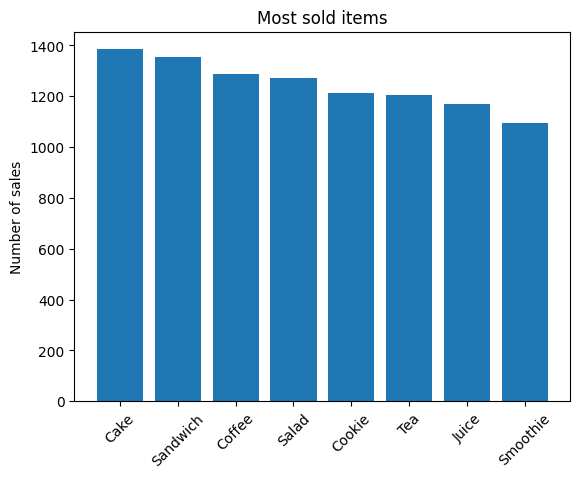

In [15]:
plt.bar(most_item_sales.index, most_item_sales.values)
plt.xticks(rotation=45)
plt.ylabel('Number of sales')
plt.title('Most sold items')
plt.show()

In [16]:
# most sold item in the takeaway location
sold_items_takeaway = df[df['Location'] == 'Takeaway']['Item'].value_counts().sort_values(ascending=False)
sold_items_takeaway

Item
Cake        419
Sandwich    412
Cookie      402
Coffee      395
Salad       378
Tea         368
Juice       339
Smoothie    303
Name: count, dtype: int64

In [17]:
# most sold item in the in-store location
sold_items_inStore = df[df['Location'] == 'In-store']['Item'].value_counts().sort_values(ascending=False)
sold_items_inStore

Item
Sandwich    429
Salad       404
Cake        400
Cookie      371
Tea         368
Juice       361
Coffee      352
Smoothie    321
Name: count, dtype: int64

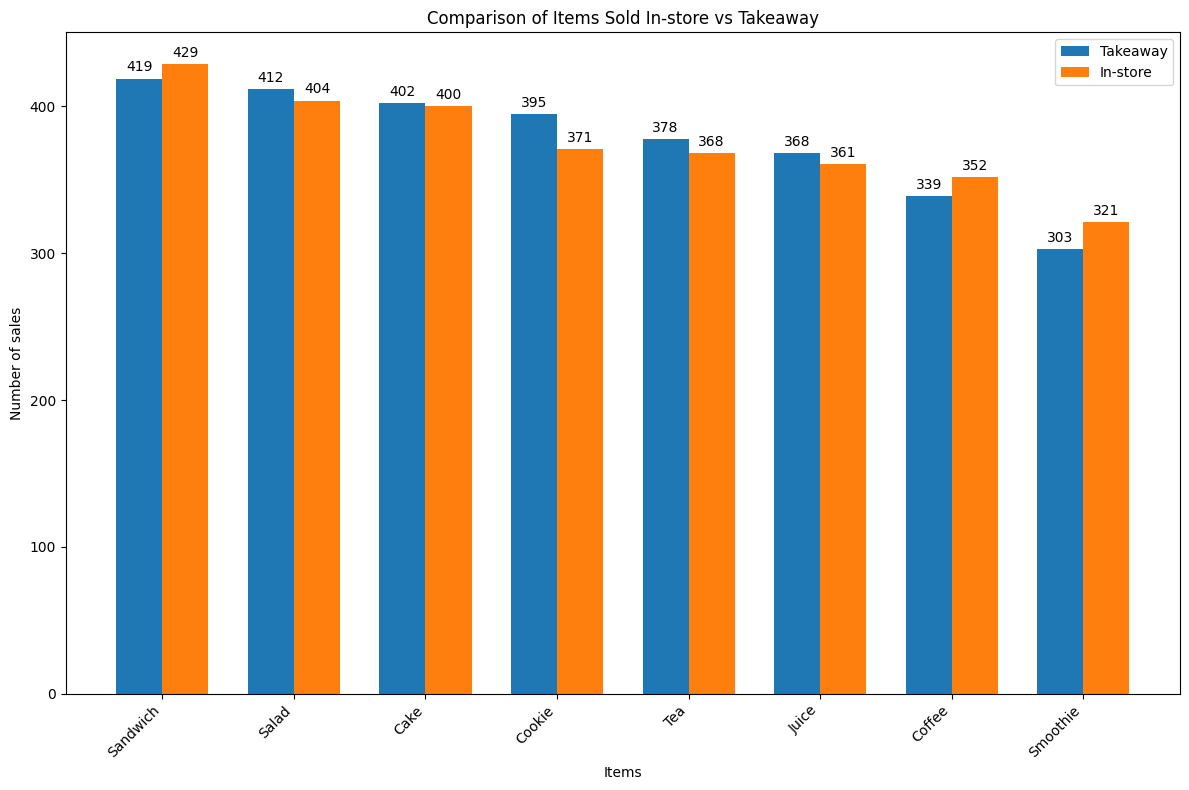

In [18]:
x = np.arange(len(sold_items_inStore.index.unique()))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, sold_items_takeaway.values, width, label='Takeaway')
bars2 = ax.bar(x + width/2, sold_items_inStore.values, width, label='In-store')

ax.set_xlabel('Items')
ax.set_ylabel('Number of sales')
ax.set_title('Comparison of Items Sold In-store vs Takeaway')
ax.set_xticks(x)
ax.set_xticklabels(sold_items_inStore.index.unique(), rotation=45, ha='right')
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)

plt.tight_layout()
plt.show()

In [19]:
payments = df[~df['Payment Method'].isin(['UNKNOWN', 'ERROR'])]['Payment Method']
payments = payments.value_counts().sort_values(ascending=False)
payments

Payment Method
Digital Wallet    2284
Credit Card       2268
Cash              2254
Name: count, dtype: int64

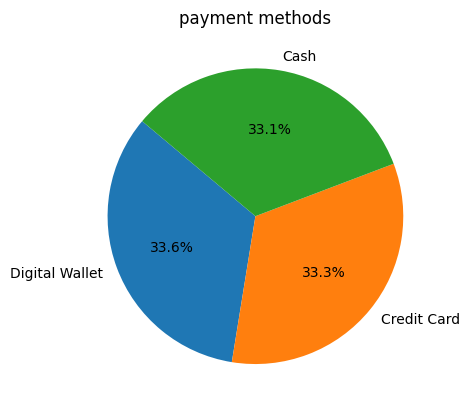

In [20]:
plt.pie(payments.values, labels=payments.index, autopct='%1.1f%%', startangle=140)
plt.title('payment methods')
plt.show()

In [21]:
payments_methods_inStore = df[df['Location'] == 'In-store']['Payment Method'].value_counts().sort_values(ascending=False)
payments_methods_inStore.drop(['UNKNOWN', 'ERROR'], inplace=True)
print(payments_methods_inStore)


Payment Method
Cash              700
Digital Wallet    692
Credit Card       679
Name: count, dtype: int64


In [22]:
payments_methods_takeaway = df[df['Location'] == 'Takeaway']['Payment Method'].value_counts().sort_values(ascending=False)
payments_methods_takeaway.drop(['UNKNOWN', 'ERROR'], inplace=True)
print(payments_methods_takeaway)

Payment Method
Digital Wallet    741
Credit Card       669
Cash              663
Name: count, dtype: int64


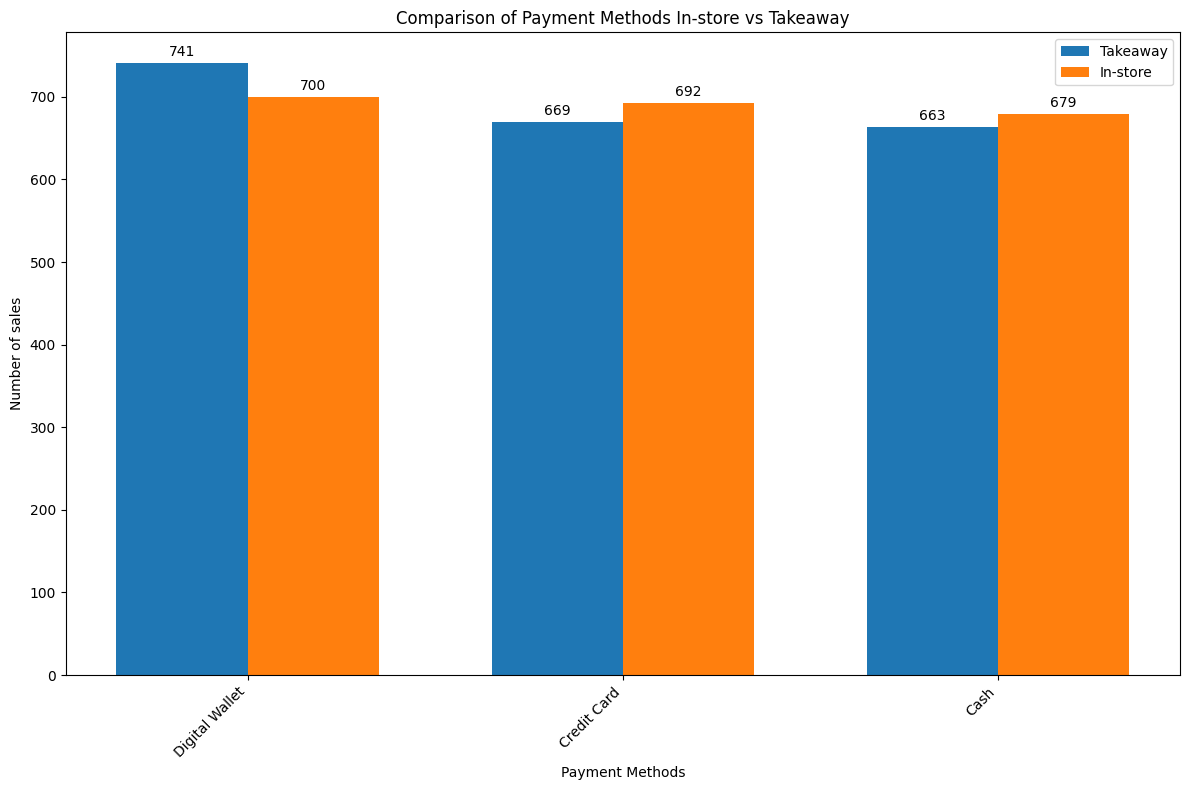

In [23]:
x = np.arange(len(payments_methods_takeaway.index.unique()))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, payments_methods_takeaway.values, width, label='Takeaway')
bars2 = ax.bar(x + width/2, payments_methods_inStore.values, width, label='In-store')

ax.set_xlabel('Payment Methods')
ax.set_ylabel('Number of sales')
ax.set_title('Comparison of Payment Methods In-store vs Takeaway')
ax.set_xticks(x)
ax.set_xticklabels(payments_methods_takeaway.index.unique(), rotation=45, ha='right')
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)

plt.tight_layout()
plt.show()

In [24]:
mean_quantity = df.groupby('Item')['Quantity'].mean().astype(int).tolist()
mean_quantity


[3, 3, 2, 3, 3, 3, 3, 3]

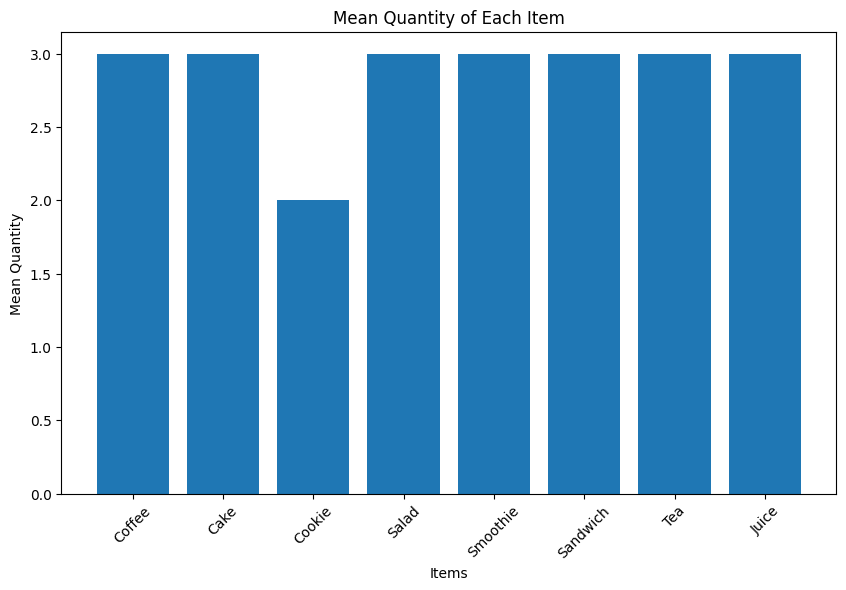

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(df['Item'].unique(), mean_quantity)
plt.xlabel('Items')
plt.ylabel('Mean Quantity')
plt.title('Mean Quantity of Each Item')
plt.xticks(rotation=45)
plt.show()

In [26]:
df

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2.0,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
...,...,...,...,...,...,...,...,...
9969,TXN_7672686,Coffee,2.0,2.0,4.0,UNKNOWN,UNKNOWN,2023-08-30
9970,TXN_9659401,Cookie,3.0,1.0,3.0,Digital Wallet,UNKNOWN,2023-06-02
9971,TXN_5255387,Coffee,4.0,2.0,8.0,Digital Wallet,UNKNOWN,2023-03-02
9972,TXN_7695629,Cookie,3.0,1.0,3.0,Digital Wallet,UNKNOWN,2023-12-02


In [27]:
# Convert 'Transaction Date' to datetime format
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

# Group by 'Transaction Date' and 'Item' and count the number of sales
sales_over_time = df.groupby(['Transaction Date', 'Item']).size().unstack(fill_value=0).resample('ME').sum()
sales_over_time

Item,Cake,Coffee,Cookie,Juice,Salad,Sandwich,Smoothie,Tea
Transaction Date,,,,,,,,
2023-01-31,113,96,97,100,113,125,69,102
2023-02-28,92,93,81,94,97,96,80,93
2023-03-31,118,115,104,104,102,106,82,95
2023-04-30,109,97,83,94,108,101,93,86
2023-05-31,102,96,93,96,95,116,89,85
2023-06-30,107,110,97,94,108,116,91,94
2023-07-31,102,102,108,75,111,108,89,94
2023-08-31,115,104,90,78,106,116,81,111
2023-09-30,121,92,99,87,84,108,93,102


In [28]:
# Apply a rolling mean with a window of 3 months
sales_over_time = sales_over_time.rolling(window=3, min_periods=1).mean()

# Select the top 5 items
top_items = sales_over_time.mean().nlargest(5).index
sales_filtered = sales_over_time[top_items]
sales_filtered

Item,Cake,Sandwich,Salad,Coffee,Tea
Transaction Date,,,,,
2023-01-31,113.000000,125.000000,113.000000,96.000000,102.000000
2023-02-28,102.500000,110.500000,105.000000,94.500000,97.500000
2023-03-31,107.666667,109.000000,104.000000,101.333333,96.666667
2023-04-30,106.333333,101.000000,102.333333,101.666667,91.333333
2023-05-31,109.666667,107.666667,101.666667,102.666667,88.666667
2023-06-30,106.000000,111.000000,103.666667,101.000000,88.333333
2023-07-31,103.666667,113.333333,104.666667,102.666667,91.000000
2023-08-31,108.000000,113.333333,108.333333,105.333333,99.666667
2023-09-30,112.666667,110.666667,100.333333,99.333333,102.333333


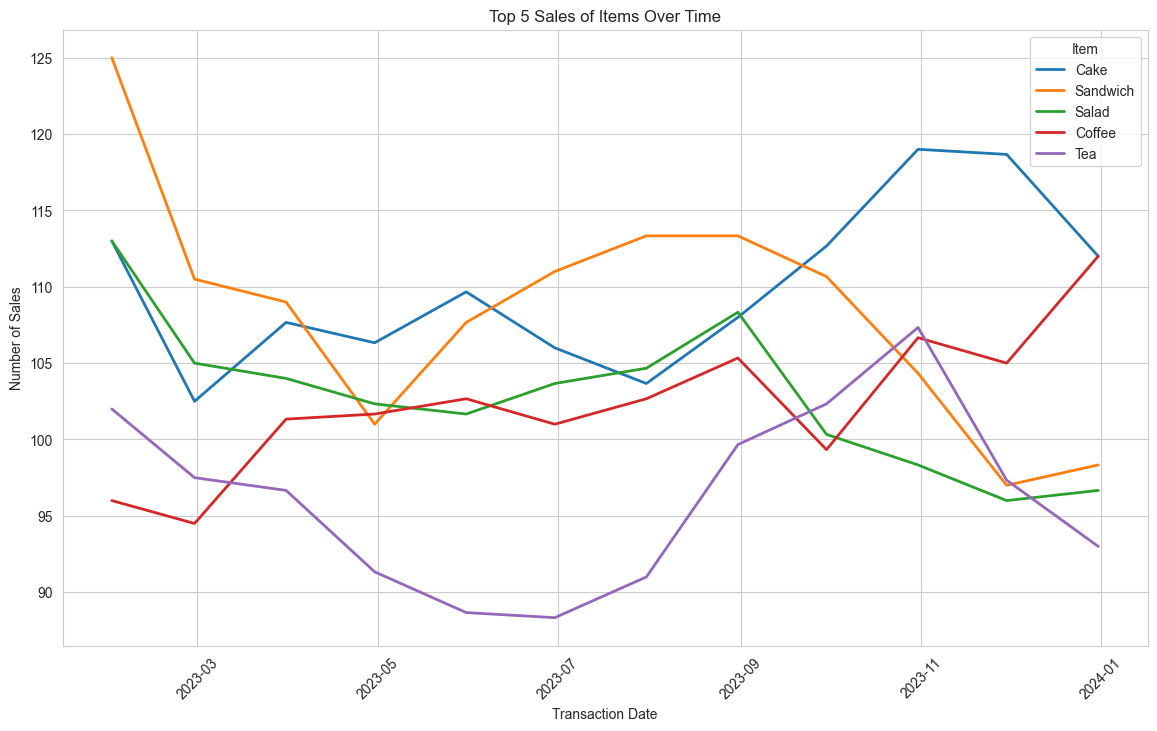

In [29]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.color_palette("tab10")

for item in sales_filtered.columns:
    plt.plot(sales_filtered.index, sales_filtered[item], label=item, linewidth=2)

plt.xlabel('Transaction Date')
plt.ylabel('Number of Sales')
plt.title('Top 5 Sales of Items Over Time')
plt.legend(title='Item')
plt.xticks(rotation=45)
plt.show()


In [30]:
# Convert 'Transaction Date' to datetime format
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

# Group by 'Transaction Date' and count the total number of sales
sales_over_time = df.groupby('Transaction Date').size().resample('ME').sum()

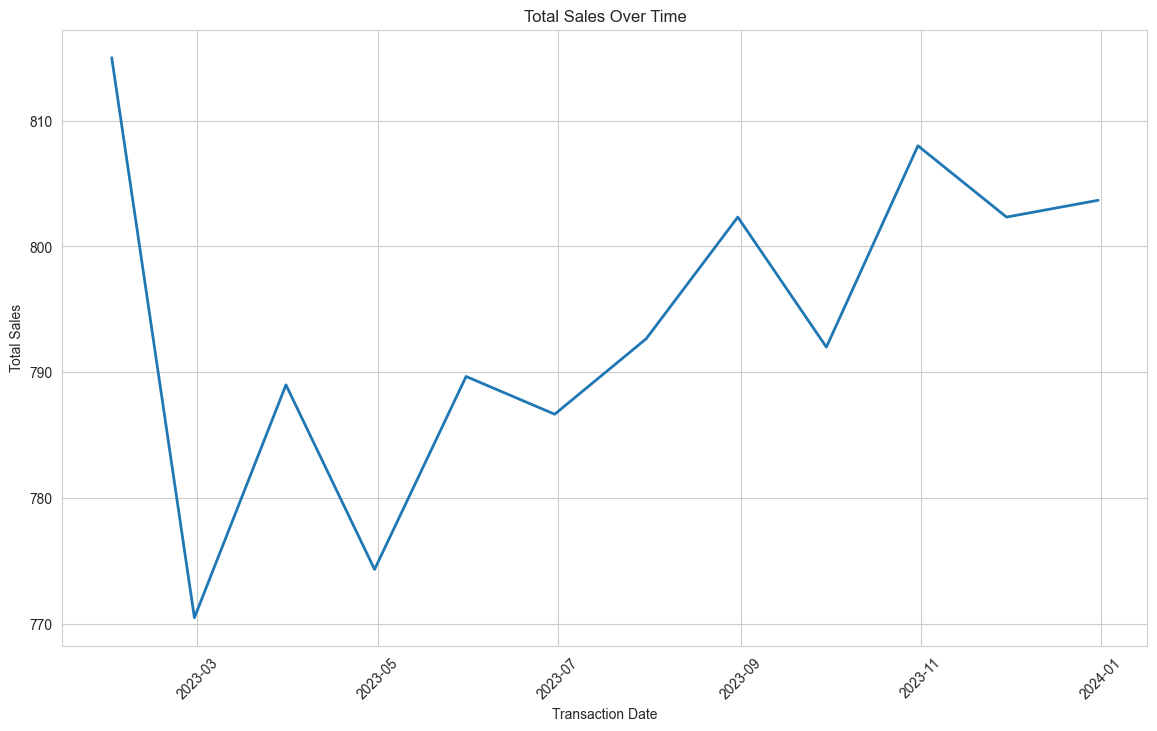

In [31]:
# Apply a rolling mean with a window of 3 months
sales_over_time = sales_over_time.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
sns.lineplot(x=sales_over_time.index, y=sales_over_time, linewidth=2)

plt.xlabel('Transaction Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time')
plt.xticks(rotation=45)
plt.show()
